# Simple Decision Tree for Continous Variable for Electric bill rate prediction

### Import Libraries

In [190]:
import warnings
warnings.filterwarnings('ignore')

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import tree

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import subplots

### Import Dataset

#### Dataset : 
    Electricity bill charges for over 22 months
#### Columns:
     1   Read Date            Date the meter reading is recorded 
     2   Usage                Monthly usage in KW 
     3   Number of Days       No. of days the bill for generated  
     4   Usage per day        Daily Usage in KW
     5   Charge               Monthly Charges
     6   Read Type            Type of read
     7   Average Temperature  Average temperature of the city during the month

In [192]:
data = pd.read_csv('..//./csv/electricity_bill.csv')
df = pd.DataFrame(data)
df.head(5)

,Read Date,Usage,Number of Days,Usage per day,Charge,Read Type,Average Temperature
0,5/6/2024,896,31,28.90,$231.65,Normal Read,54.2
1,4/5/2024,941,29,32.45,$242.07,Normal Read,44.2
2,3/7/2024,1140,31,36.77,$288.26,Normal Read,37.1
3,2/5/2024,1205,31,38.87,$303.33,Normal Read,33.4
4,1/5/2024,997,31,32.16,$255.08,Normal Read,38.3


### Basic Validation

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Read Date            21 non-null     object 
 1   Usage                21 non-null     int64  
 2   Number of Days       21 non-null     int64  
 3   Usage per day        21 non-null     float64
 4   Charge               21 non-null     object 
 5   Read Type            21 non-null     object 
 6   Average Temperature  21 non-null     float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ KB


In [194]:
df.isna().sum()
df.duplicated().sum()
df.isnull().sum()

Read Date              0
Usage                  0
Number of Days         0
Usage per day          0
Charge                 0
Read Type              0
Average Temperature    0
dtype: int64

#### Removing Dollar sign from Charge column and changing datatype to float

In [195]:
df['Charge'] = df['Charge'].str.replace('$','')
df['Charge'] = df['Charge'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Read Date            21 non-null     object 
 1   Usage                21 non-null     int64  
 2   Number of Days       21 non-null     int64  
 3   Usage per day        21 non-null     float64
 4   Charge               21 non-null     float64
 5   Read Type            21 non-null     object 
 6   Average Temperature  21 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.3+ KB


#### Statistical Description

In [196]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Usage,21.0,733.238095,299.461167,75.00,509.00,708.00,934.00,1225.00
Number of Days,21.0,29.190476,5.715059,6.00,29.00,31.00,31.00,34.00
Usage per day,21.0,24.536667,8.353931,12.50,17.12,24.41,30.52,38.87
Charge,21.0,194.975714,76.234617,21.04,134.29,194.12,246.00,323.78
Average Temperature,21.0,51.595238,13.831756,33.40,38.30,53.90,62.70,75.60


### Correlation
        1. The target 'Charge is strongly correlated with Usage positively and Avg Temperature Negatively

In [197]:
numeric_col = [col for col in df.columns if df[col].dtypes != 'O']
cat_col = [col for col in df.columns if df[col].dtypes == 'O']
df[numeric_col].corr()

,Usage,Number of Days,Usage per day,Charge,Average Temperature
Usage,1.000000,0.594501,0.961624,0.975295,-0.877059
Number of Days,0.594501,1.000000,0.373512,0.561785,-0.314159
Usage per day,0.961624,0.373512,1.000000,0.961215,-0.926805
Charge,0.975295,0.561785,0.961215,1.000000,-0.904655
Average Temperature,-0.877059,-0.314159,-0.926805,-0.904655,1.000000


<Axes: >

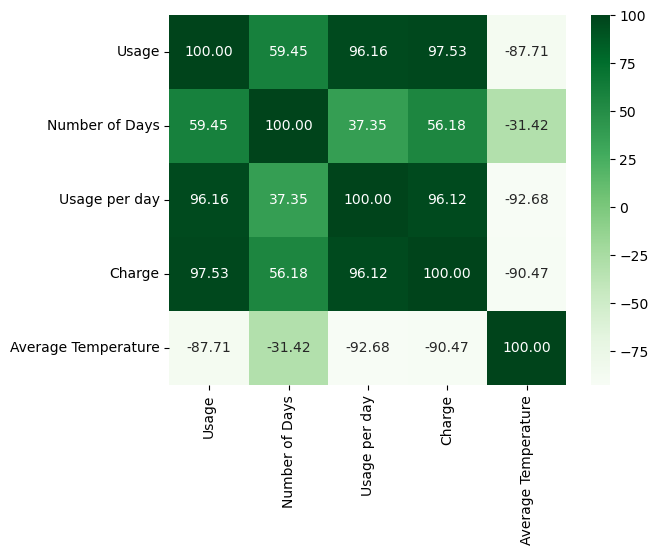

In [198]:
sns.heatmap(df[numeric_col].corr()*100,annot=True,cmap='Greens',fmt='.2f')

In [199]:
df.columns

Index(['Read Date', 'Usage', 'Number of Days', 'Usage per day', 'Charge',
       'Read Type', 'Average Temperature'],
      dtype='object')

#### Droping unwanted column

In [200]:
df.drop(labels=['Read Date','Read Type'],axis=1,inplace=True)

#### Encoding the categorical variables

In [201]:
label_encoder = LabelEncoder()
cat_cols = [col for col in df.columns if df.dtypes[col] == 'O']
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Model 1 : Simple Decision Tree Regressor

In [202]:
x_col =  ['Usage', 'Number of Days', 'Usage per day',  
       'Average Temperature']
X = df[x_col]
y = df['Charge']
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [203]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [204]:
y_pred = dt_model.predict(X_test)

#### Model Metrics

In [205]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('r2_score:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 18.385999999999996
Mean Squared Error: 448.5742999999996
Root Mean Squared Error: 21.179572705793657
r2_score: 0.8432975573433499


#### Visualization

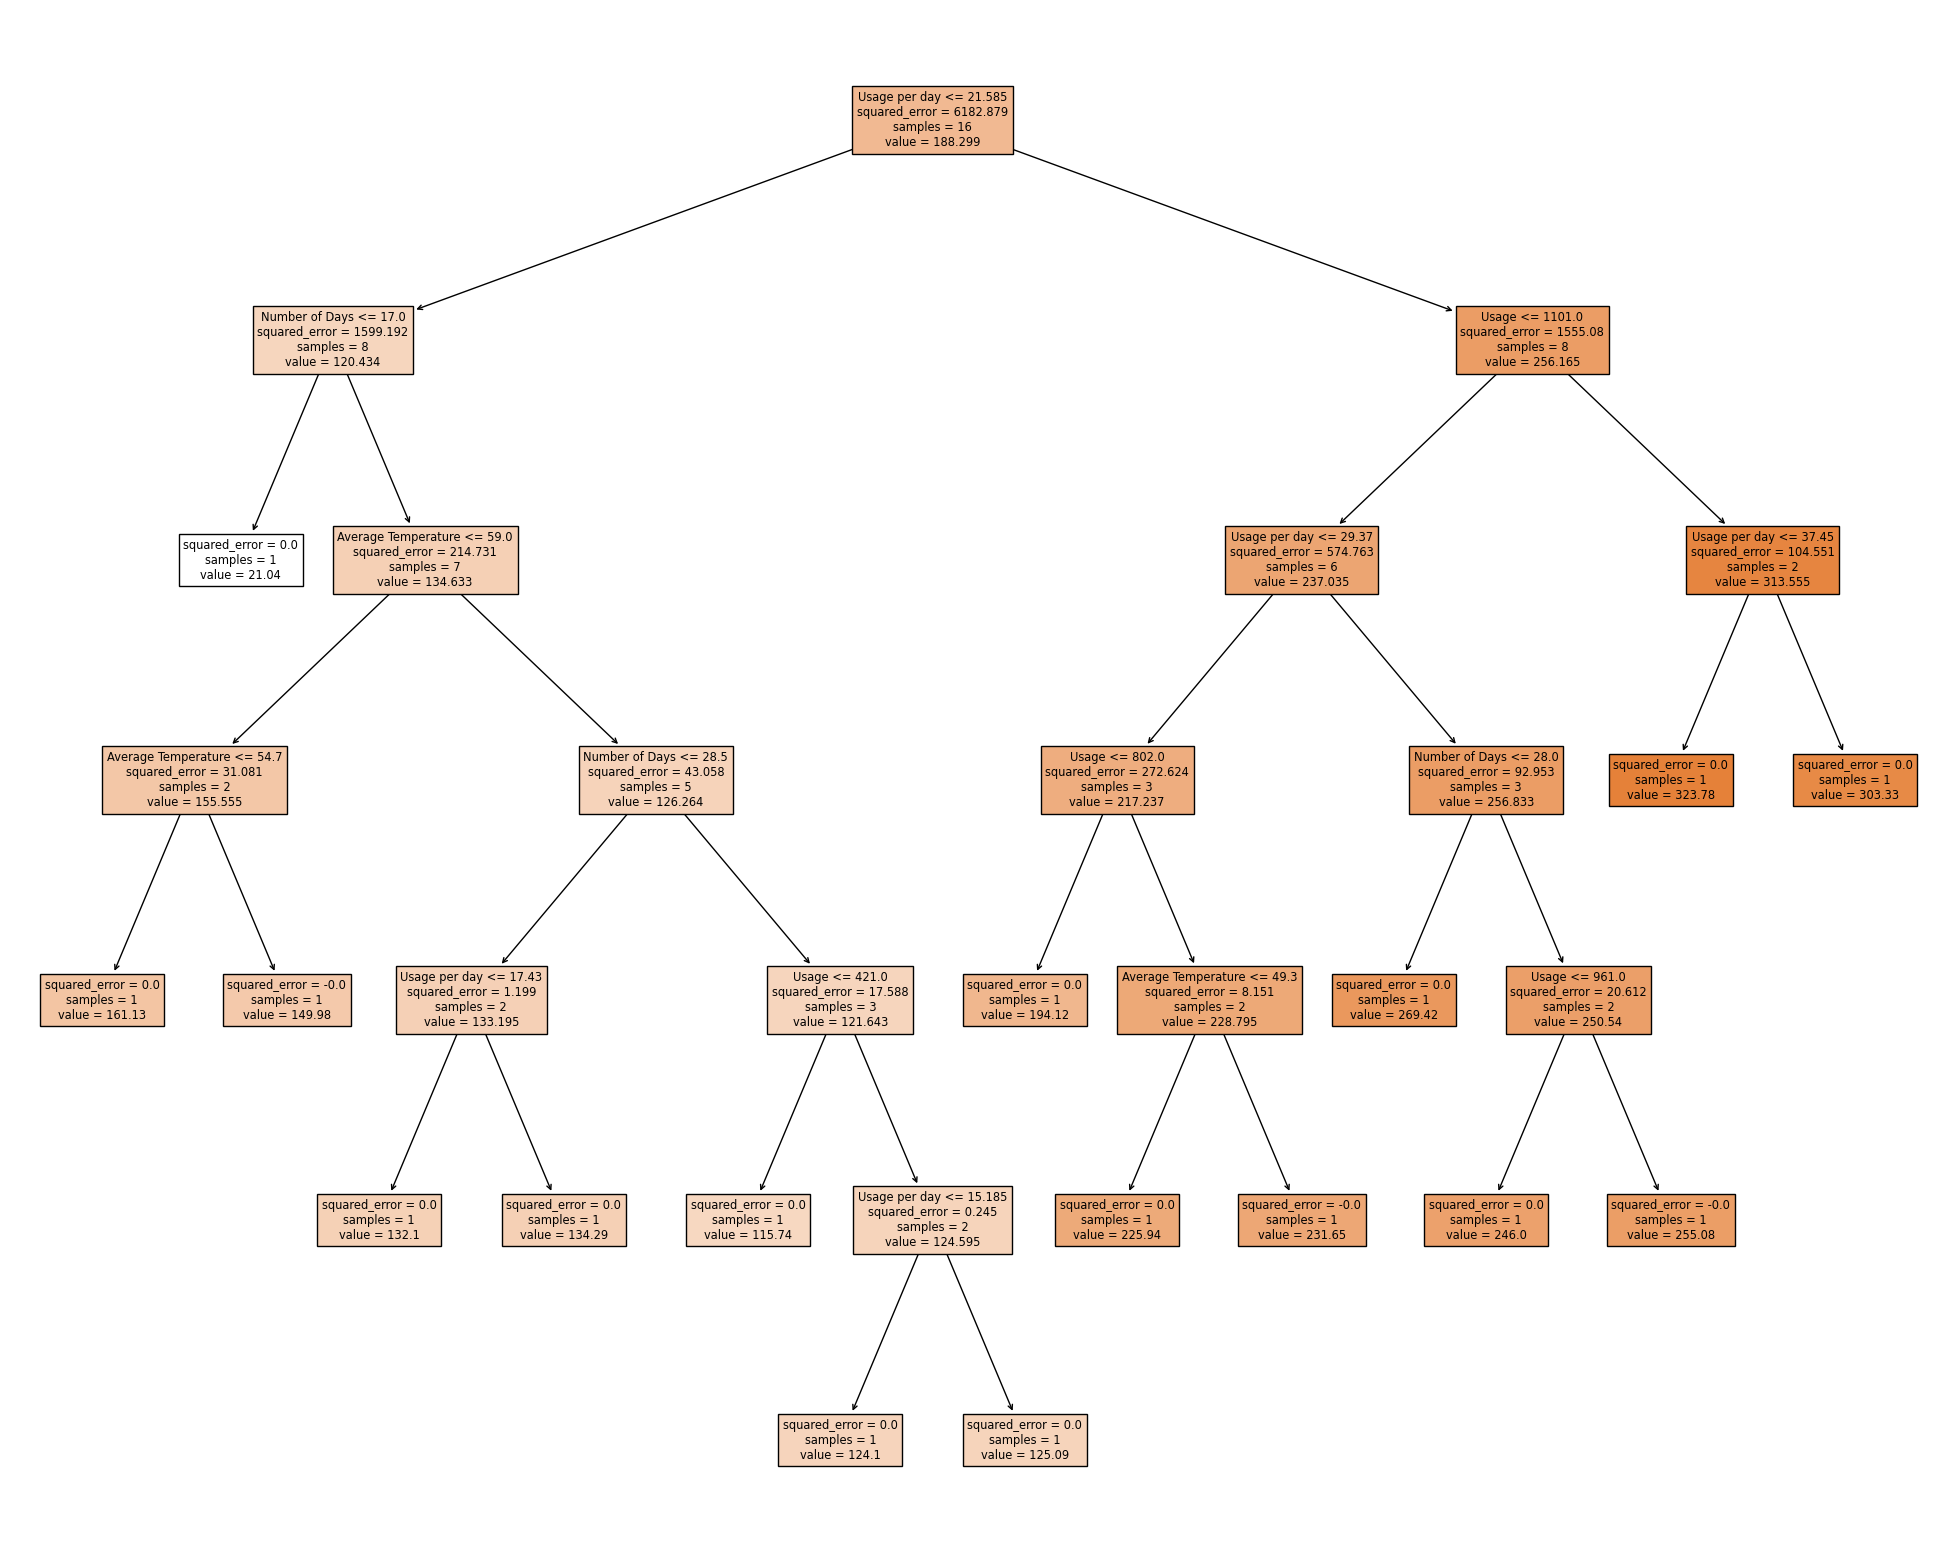

In [206]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_model,
                   feature_names=X.columns,
                   filled=True)

#### Feature Importance

In [207]:
dt_model.feature_importances_
feature_sel = pd.Series(dt_model.feature_importances_,index=x_col)
feature_sel.sort_values(ascending=False)

Usage per day          0.770835
Number of Days         0.118151
Usage                  0.097831
Average Temperature    0.013183
dtype: float64

# Model 2 : Decision Tree Regressor with Hyper parameter Tuning

In [208]:
x_col =  ['Usage', 'Average Temperature']
X = df[x_col]
y = df['Charge']
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=7)

#### Grid Search DV with 3 folds

In [209]:
dt_model = DecisionTreeRegressor(random_state=7)
params = { 'splitter' : ['best','random'],
           'max_depth' : range(1, 15),
           'min_samples_leaf' : range(1, 15),
           'min_weight_fraction_leaf' : np.linspace(0.1,1,10),
           'max_leaf_nodes':range(10,101,10), 
           }
Grid_search = GridSearchCV(estimator=dt_model,param_grid=params,cv =3, verbose=True, scoring='neg_mean_squared_error')
Grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 39200 candidates, totalling 117600 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=7),
             param_grid={'max_depth': range(1, 15),
                         'max_leaf_nodes': range(10, 101, 10),
                         'min_samples_leaf': range(1, 15),
                         'min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error', verbose=True)

#### Best Parameters

In [216]:
Grid_search.best_params_

{'max_depth': 4,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'random'}

In [220]:
dt_model_tuned = DecisionTreeRegressor(max_depth =4,
                                   max_leaf_nodes = 10,    
                                  min_samples_leaf = 1,
                                min_weight_fraction_leaf = 0.1,
                                 splitter = 'random')
dt_model_tuned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                      min_weight_fraction_leaf=0.1, splitter='random')

In [221]:
y_pred_tuned = dt_model_tuned.predict(X_test)

#### Model Metrics

In [222]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred_tuned))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,y_pred_tuned))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_tuned)))
print('r2_score:', metrics.r2_score(y_test,y_pred_tuned))

Mean Absolute Error: 6.609666666666664
Mean Squared Error: 46.97586055555548
Root Mean Squared Error: 6.853893824356741
r2_score: 0.9835897150261311


#### Visualization

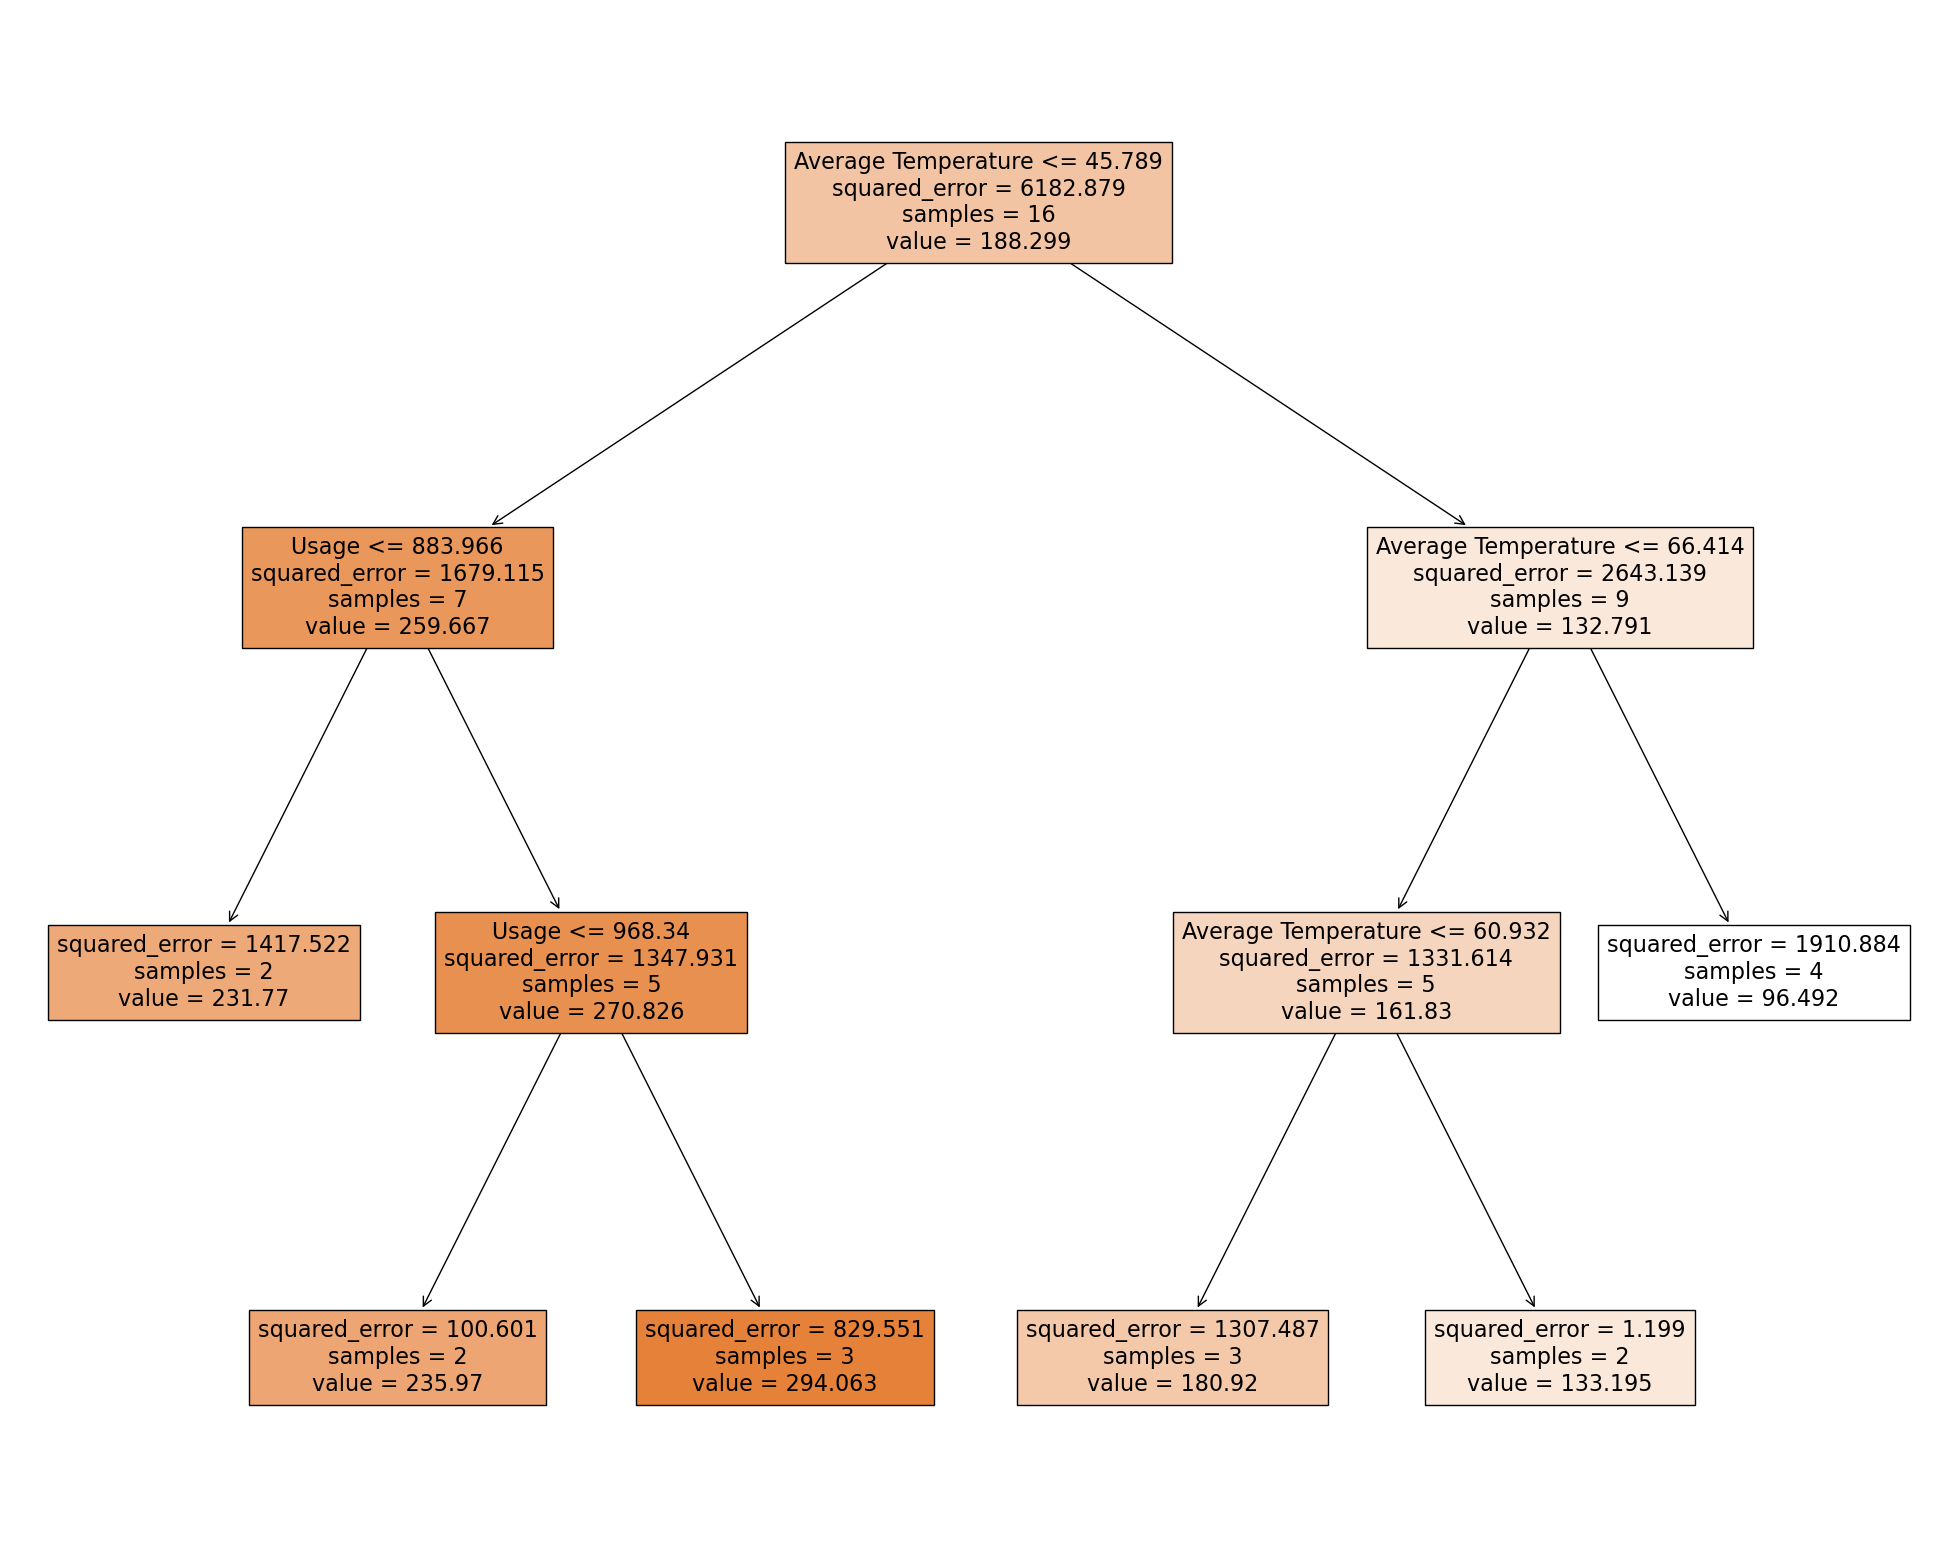

In [223]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_model_tuned,
                   feature_names=X.columns,
                   filled=True)

### Visualizing Decision Boundry

In [ ]:
fig = subplots.make_subplots(rows=1, cols=1,x_title='Usage per day',y_title='Average Temperature')

h = .02  # step size in the mesh
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h)
                     , np.arange(y_min, y_max, h))
y_ = np.arange(y_min, y_max, h)

Z = dt_model_tuned.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

trace1 = go.Heatmap(x=xx[0], y=y_, z=Z,
                  colorscale='Viridis',
                  showscale=False)

trace2 = go.Scatter(x=X.iloc[:, 0], y=X.iloc[:, 1], 
                    mode='markers',                    
                    showlegend=False,
                    marker=dict(size=10,
                                color=df['Charge'],
                                colorscale='Viridis',
                                line=dict(color='black', width=1))
                    )
                  
fig.add_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.update_layout(height=600, width=800, title_text="Decision Boundary Visulaization")
py.iplot(fig)

### References
    https://www.youtube.com/watch?v=UhY5vPfQIrA
    https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
    https://www.kaggle.com/code/arthurtok/decision-boundaries-visualised-via-python-plotly

### Inpretation
    Model 2 with tuned hyper parameters gives less RSME and better r2 score
    
    The decision tree regressor is slightly different from Linear regression. The concept is beautifully explained in the you tube channel Normalized Nerd in references with clear visualization